## Import statements

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

## Exploratory Data Analysis

In [10]:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

In [11]:
print "Rows: ", df.shape[0]
print "Columns: ", df.shape[1]
df.head()

Rows:  110527
Columns:  14


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Notice that values for "Gender" and "No-show" are strings instead of bool. These will need to be transformed  before they can be used as features for machine learning. There's also an opportunity to do One-Hot encoding on "Neighbourhood" to split each variable into a feature for machine learning.

In [12]:
df.isnull().any()

PatientId         False
AppointmentID     False
Gender            False
ScheduledDay      False
AppointmentDay    False
Age               False
Neighbourhood     False
Scholarship       False
Hipertension      False
Diabetes          False
Alcoholism        False
Handcap           False
SMS_received      False
No-show           False
dtype: bool

There are no null-values in the dataset which indicates it has already been cleaned for missing values.

## Data Wrangling

In [13]:
# Replace 'M' and 'F' with 1 and 0 for 'Gender' and 'Yes' and 'No'
# with 1 and 0 for 'No-show'
df['Gender'] = df['Gender'].map({'M':1, 
                                 'F':0}
                               )
df['No-show'] = df['No-show'].map({'Yes':1, 
                                   'No':0}
                                 )

In [14]:
# Renaming columns to fix typos, inconsistency and spelling mistakes
df.rename(columns={'AppointmentID':'AppointmentId',
                   'Handcap':'Handicap', 
                   'Hipertension':'Hypertension'}, 
          inplace=True
         )

df.head()

,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
0,2.987250e+13,5642903,0,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,0
1,5.589978e+14,5642503,1,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,0
2,4.262962e+12,5642549,0,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,0
3,8.679512e+11,5642828,0,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0
4,8.841186e+12,5642494,0,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,0


In [15]:
def no_show_class():
    '''Count the values of No-show to spot whether classes are imbalanced or not'''
    no_show = 0
    for value in df['No-show']:
        if value == 1:
            no_show += 1
    print "\n Out of", len(df['No-show']), "records,", no_show, "didn't show up, i.e.", round(float(no_show) / float(len(df['No-show'])), 4)*100,"%"

print "Below is the split of values in 'No-show': 0 = showed up and 1 = didn't show up: \n"
print df['No-show'].value_counts()
no_show_class()

Below is the split of values in 'No-show': 0 = showed up and 1 = didn't show up: 

0    88208
1    22319
Name: No-show, dtype: int64

 Out of 110527 records, 22319 didn't show up, i.e. 20.19 %


Classes of 'No-show' are imbalanced and something we have to take into account when the dataset is going to be split into train and test. A stratified shuffle split is likely going to be ideal for cross-validating our machine learning model due to its randomised validations to increase the likelihood of the imbalanced classes for cross validation.

In [16]:
# Checking the range for 'Age' to spot outliers
print "Age range: ", sorted(df['Age'].unique())

Age range:  [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 115]


The youngest patient is -1 years old and the oldest is 115. It is clear the the youngest patient has to be removed since it's an impossibility and an outlier in our machine learning model. Likewise with patients older than 100.

Text(0.5,1,u'Distribution of Age')

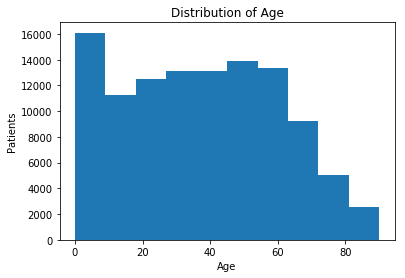

In [22]:
# Distribution of 'Age'
plt.figure();
age_hist = df['Age'].plot.hist(bins=10)
age_hist.set_xlabel("Age")
age_hist.set_ylabel("Patients")
age_hist.set_title('Distribution of Age')

It is apparent from the histogram above that patients aged above 90 are few and outliers.

In [18]:
# Only keep records of patients where they are between 0-90 in age to remove outliers.
df = df[(df.Age >= 0) & (df.Age <= 90)]

min_age = df['Age'].min()
max_age = df['Age'].max()
print "Age now spans values from: {} to {}.".format(min_age, max_age)

Age now spans values from: 0 to 90.


0    71619
1    38599
Name: Gender, dtype: int64


Text(0.5,1,u'Distribution of Gender')

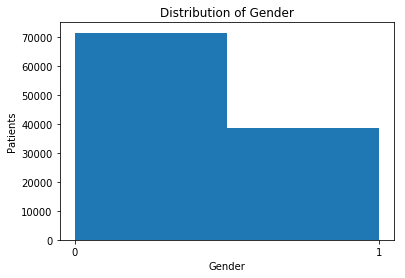

In [21]:
# Gender split
print df['Gender'].value_counts()
gender_hist = df['Gender'].plot.hist(bins=2)
gender_hist.set_xlabel("Gender")
gender_hist.set_xticks([0, 1])
gender_hist.set_ylabel("Patients")
gender_hist.set_title('Distribution of Gender')

There are almost twice as many female patients in this dataset than male.

## Feature Engineering

In [110]:
# Transforming ScheduledDay and AppointmentDay into datetime objects and stripping hours, minutes and seconds.
dt_scheduledDay =  pd.to_datetime(df.ScheduledDay).dt.date
dt_appointmentDay = pd.to_datetime(df.AppointmentDay).dt.date

# Storing "delta_days" to df as a new feature
df['days_delta'] = (dt_appointmentDay - dt_scheduledDay).dt.days
df.head()

,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,days_delta
0,2.987250e+13,5642903,0,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,0,0
1,5.589978e+14,5642503,1,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,0,0
2,4.262962e+12,5642549,0,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,0,0
3,8.679512e+11,5642828,0,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,0
4,8.841186e+12,5642494,0,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,0,0


In [154]:
# Exploring features and content to spot identifiers and to separate categorical from numerical columns for modelling later
print "PatientId: ", df.PatientId.unique(), "\n   Unique values: ", len(df.PatientId.unique())
print "AppointmentId: ", df.AppointmentId.unique(), "\n   Unique values: ", len(df.AppointmentId.unique())
print "Gender: ", df.Gender.unique()
print "ScheduledDay: ", df.ScheduledDay.unique(), "\n  Unique values: ", len(df.ScheduledDay.unique())
print "AppointmentDay: ", df.AppointmentDay.unique(), "\n  Unique values: ", len(df.AppointmentDay.unique())
print "Age: ", sorted(df.Age.unique()), "\n Unique values: ", len(df.Age.unique())
print "SMS_received: ", df.SMS_received.unique()
print "Scholarship: ", df.Scholarship.unique()
print "Hypertension: ", df.Hypertension.unique()
print "Diabetes: ", df.Diabetes.unique()
print "Alcoholism: ", df.Alcoholism.unique()
print "Handicap: ", df.Handicap.unique()
print "No-show: ", df["No-show"].unique()
print "Days delta: ", sorted(df.days_delta.unique())
print "Neighbourhood: ", df.Neighbourhood.unique(), "\n  Unique values: ", len(df.Neighbourhood.unique())

PatientId:  [  2.98724998e+13   5.58997777e+14   4.26296230e+12 ...,   7.26331493e+13
   9.96997666e+14   1.55766317e+13] 
   Unique values:  62113
AppointmentId:  [5642903 5642503 5642549 ..., 5630692 5630323 5629448] 
   Unique values:  110218
Gender:  [0 1]
ScheduledDay:  ['2016-04-29T18:38:08Z' '2016-04-29T16:08:27Z' '2016-04-29T16:19:04Z' ...,
 '2016-04-27T16:03:52Z' '2016-04-27T15:09:23Z' '2016-04-27T13:30:56Z'] 
  Unique values:  103274
AppointmentDay:  ['2016-04-29T00:00:00Z' '2016-05-03T00:00:00Z' '2016-05-10T00:00:00Z'
 '2016-05-17T00:00:00Z' '2016-05-24T00:00:00Z' '2016-05-31T00:00:00Z'
 '2016-05-02T00:00:00Z' '2016-05-30T00:00:00Z' '2016-05-16T00:00:00Z'
 '2016-05-04T00:00:00Z' '2016-05-19T00:00:00Z' '2016-05-12T00:00:00Z'
 '2016-05-06T00:00:00Z' '2016-05-20T00:00:00Z' '2016-05-05T00:00:00Z'
 '2016-05-13T00:00:00Z' '2016-05-09T00:00:00Z' '2016-05-25T00:00:00Z'
 '2016-05-11T00:00:00Z' '2016-05-18T00:00:00Z' '2016-05-14T00:00:00Z'
 '2016-06-02T00:00:00Z' '2016-06-03T00:00:00Z

Text(0.5,1,u'Distribution of Days delta')

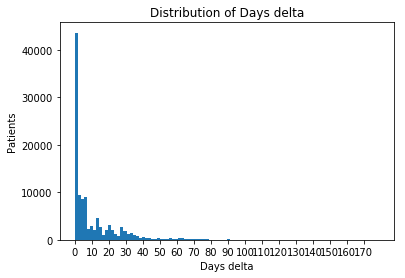

In [161]:
# days_delta contains impossible values such as -6 and -1 which look like mistakes/outliers but requires further investigation

days_hist = df['days_delta'].plot.hist(bins=100)
days_hist.set_xlabel("Days delta")
days_hist.set_xticks(range(0, 180, 10))
days_hist.set_ylabel("Patients")
days_hist.set_title('Distribution of Days delta')

In [162]:
# days_delta < 0 and > 90 are not on the histogram which indicates that they don't belong to a patient/few patients and therefore should be removed.
df = df[(df.days_delta >= 0) & (df.days_delta <= 90)]
print "Days delta: ", sorted(df.days_delta.unique())

Days delta:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]


In [163]:
# Creating vars to hold categorical and numerical features
num_features_for_encoding = ['Age', 'days_delta'] 
cat_features_for_encoding = ['Handicap', 'Neighbourhood']

## Feature Selection


In [164]:
# Separating out features and labels for preprocessing
features = df.iloc[:, :13]
labels = df.iloc[:, 13:]
print features.head()

      PatientId  AppointmentId  Gender          ScheduledDay  \
0  2.987250e+13        5642903       0  2016-04-29T18:38:08Z   
1  5.589978e+14        5642503       1  2016-04-29T16:08:27Z   
2  4.262962e+12        5642549       0  2016-04-29T16:19:04Z   
3  8.679512e+11        5642828       0  2016-04-29T17:29:31Z   
4  8.841186e+12        5642494       0  2016-04-29T16:07:23Z   

         AppointmentDay  Age      Neighbourhood  Scholarship  Hypertension  \
0  2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0             1   
1  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             0   
2  2016-04-29T00:00:00Z   62      MATA DA PRAIA            0             0   
3  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI            0             0   
4  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             1   

   Diabetes  Alcoholism  Handicap  SMS_received  
0         0           0         0             0  
1         0           0         0             

In [165]:
# Feature selection using SelectKBest
X_new = SelectKBest(chi2, k=5).fit_transform(features[num_features], labels)


ValueError: Multioutput target data is not supported with label binarization

This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row.
‘ScheduledDay’ tells us on what day the patient set up their appointment.
‘Neighborhood’ indicates the location of the hospital.
‘Scholarship’ indicates whether or not the patient is enrolled in Brasilian welfare program Bolsa Família.
Be careful about the encoding of the last column: it says ‘No’ if the patient showed up to their appointment, and ‘Yes’ if they did not show up.

What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment?